Import Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ReLU, GlobalAveragePooling2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

import tarfile
import os
import pickle
import warnings
import webbrowser
import numpy as np
import pandas as pd
import seaborn as sns
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

warnings.filterwarnings("ignore")

C:\Users\MSI\AppData\Local\Temp\ipykernel_21428\1997305095.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


1.0 Data Import & Understanding

1.1 Extract the CIFAR-10 Dataset

In [ ]:
file_path = "C:/Users/MSI/Downloads/cifar-10-python.tar.gz"
extract_path = "C:/Users/MSI/Downloads"

with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)


1.2 Load Dataset

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


1.3 Load all five training batches and one test batch

In [3]:
# Load all training data
data_dir = "C:/Users/MSI/Downloads/cifar-10-batches-py"
train_data = []
train_labels = []

for i in range(1, 6):
    batch = unpickle(os.path.join(data_dir, f"data_batch_{i}"))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']

train_data = np.concatenate(train_data)
train_labels = np.array(train_labels)

# Load test data
test_batch = unpickle(os.path.join(data_dir, "test_batch"))
test_data = test_batch[b'data']
test_labels = np.array(test_batch[b'labels'])

# Check dataset shapes
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Training data shape: (50000, 3072)
Test data shape: (10000, 3072)


1.4 Exploratory Data Analysis (EDA)

Total number of training images: 50000
Total number of classes: 10

Number of images per class:

Class
frog          5000
truck         5000
deer          5000
automobile    5000
bird          5000
horse         5000
ship          5000
cat           5000
dog           5000
airplane      5000
Name: count, dtype: int64


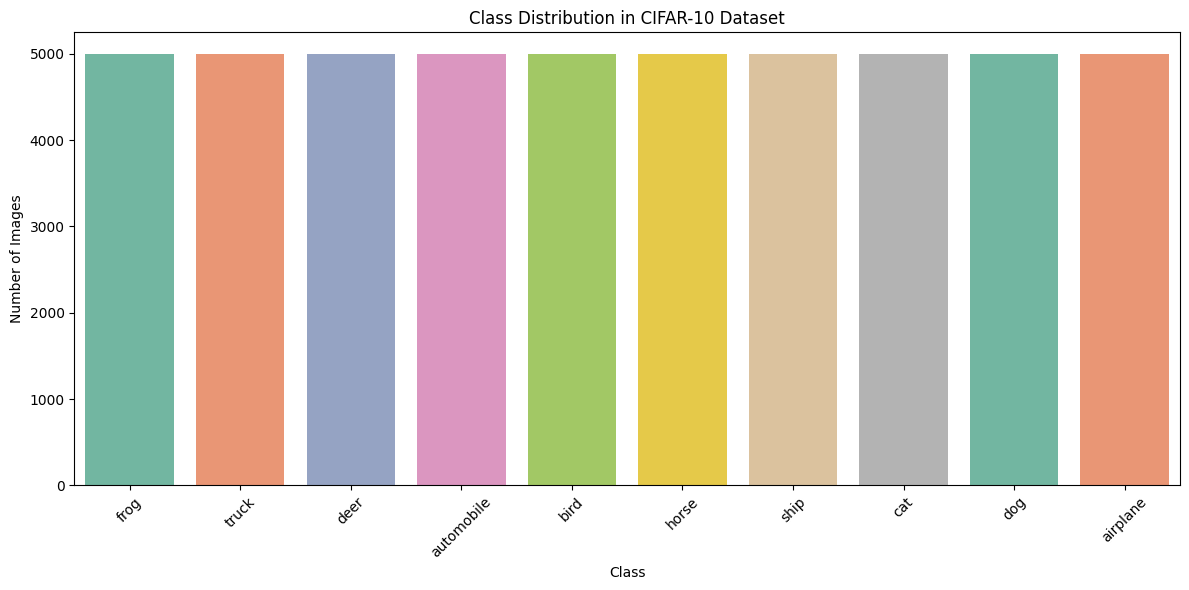

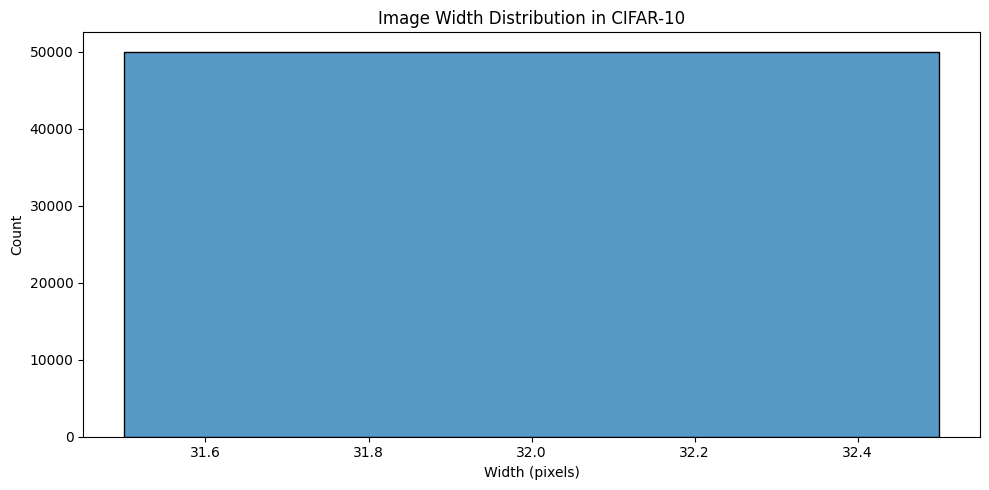

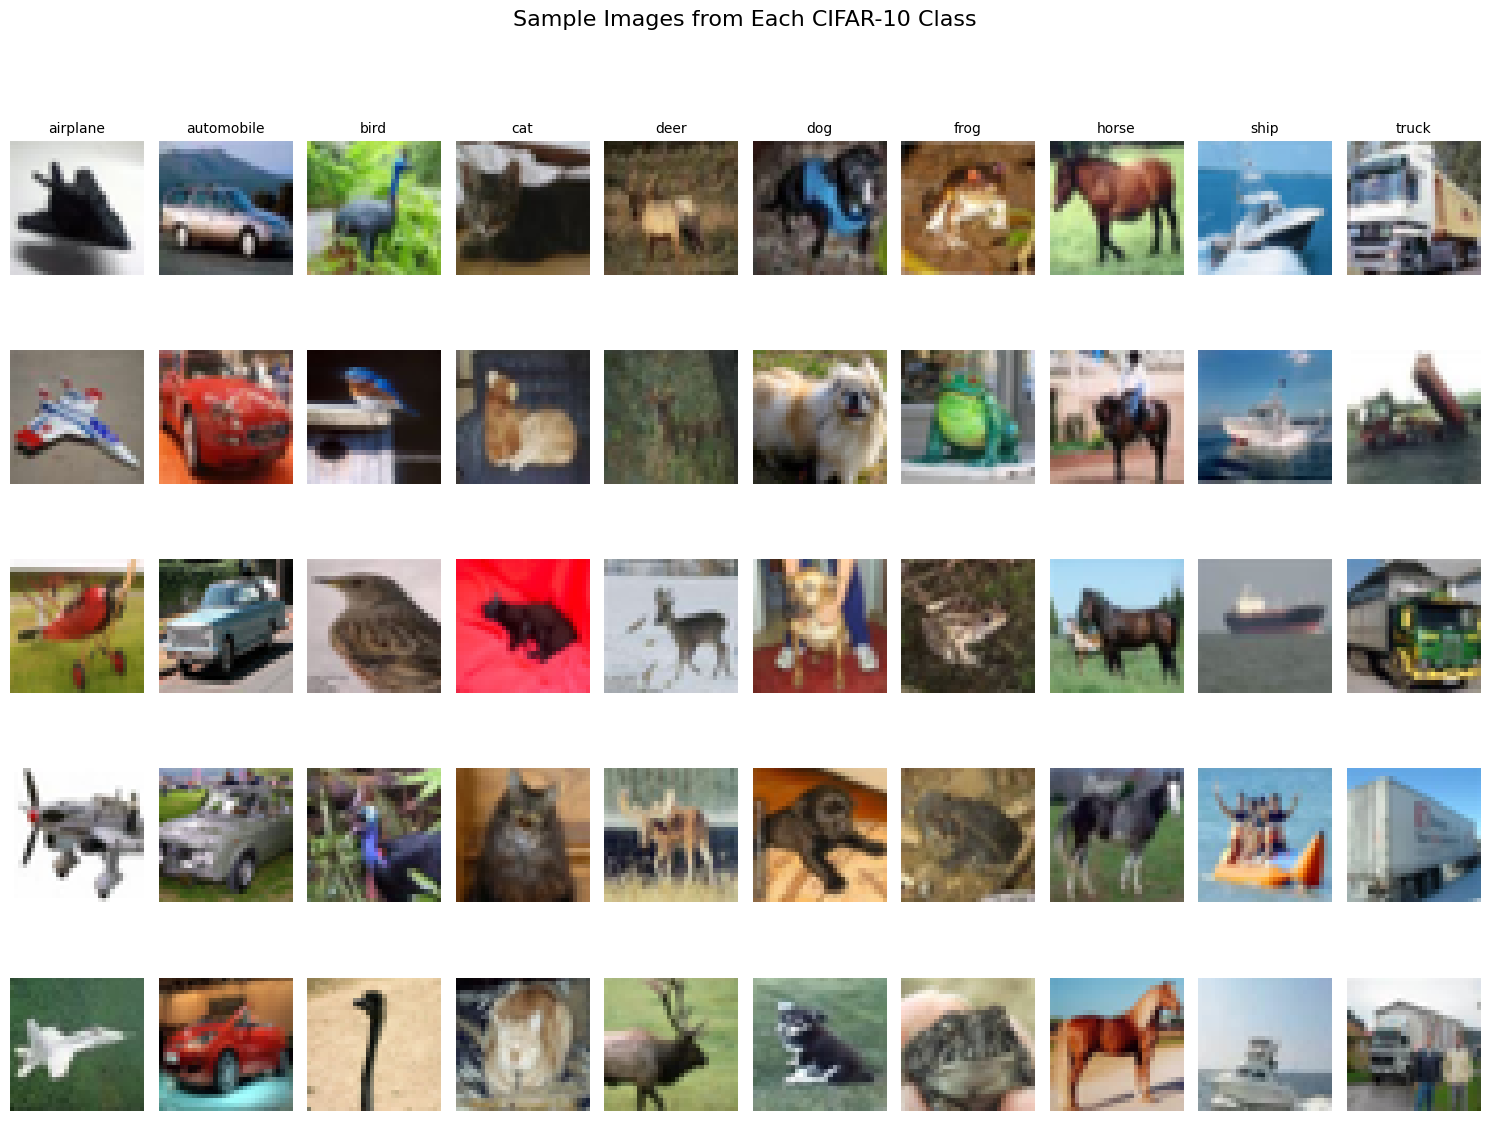

In [ ]:
# CIFAR-10 label names
meta = unpickle(os.path.join(data_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta[b'label_names']]
label_map = dict(zip(range(10), label_names))

# Create DataFrame for EDA
df = pd.DataFrame({'ClassID': train_labels})
df['Class'] = df['ClassID'].map(label_map)

# Image count and class statistics
print(f"Total number of training images: {len(df)}")
print(f"Total number of classes: {df['Class'].nunique()}")
print("\nNumber of images per class:\n")
print(df['Class'].value_counts())

# Countplot (bar chart)
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Class', order=df['Class'].value_counts().index, palette='Set2')
plt.title('Class Distribution in CIFAR-10 Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("class_distribution_bar.png")
plt.show()

# Pie chart (Plotly)
fig = px.pie(df, names='Class', title='CIFAR-10 Class Distribution', hole=0.4)
fig.update_traces(textinfo='percent+label', textfont_size=14)
fig.update_layout(title_x=0.5)
fig.write_html("class_distribution_pie.html")
# Open it in browser
# Since to enable full Plotly interactive rendering in notebook, must install Jupyter Notebook and IPython
webbrowser.open("class_distribution_pie.html")

# Image size distribution (all are 32x32 in CIFAR-10)
image_sizes = [(32, 32)] * len(train_data)
size_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
size_df['Class'] = df['Class']

plt.figure(figsize=(10, 5))
sns.histplot(size_df['Width'], bins=1, kde=False)
plt.title("Image Width Distribution in CIFAR-10")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("image_size_distribution.png")
plt.show()

X_images = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Shape: (N, 32, 32, 3)

# Plot 5 sample images for each class
plt.figure(figsize=(15, 12))
samples_per_class = 5
for class_idx, class_name in enumerate(label_names):
    class_images = X_images[np.where(train_labels == class_idx)]
    for i in range(samples_per_class):
        plt_idx = i * 10 + class_idx + 1
        plt.subplot(samples_per_class, 10, plt_idx)
        plt.imshow(class_images[i])
        plt.axis('off')
        if i == 0:
            plt.title(class_name, fontsize=10)
plt.suptitle("Sample Images from Each CIFAR-10 Class", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


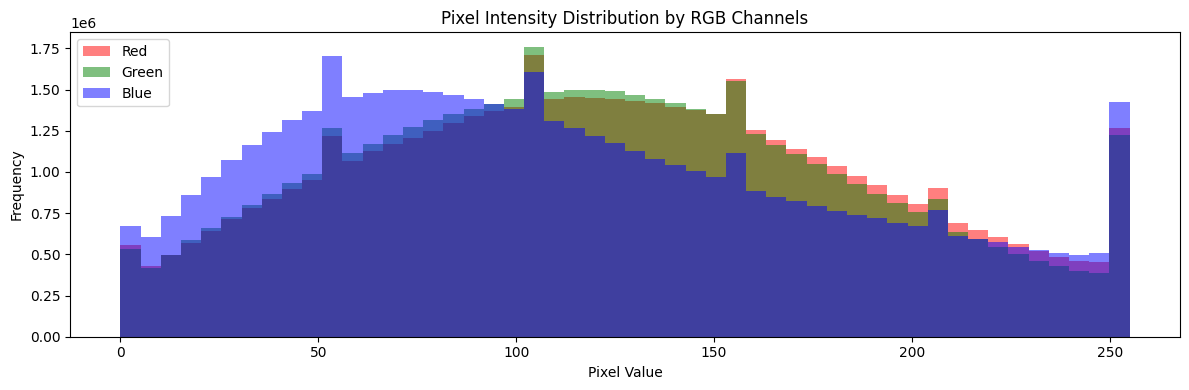

In [83]:
# Plot pixel intensity histogram for RGB channels
r_vals = X_images[:,:,:,0].flatten()
g_vals = X_images[:,:,:,1].flatten()
b_vals = X_images[:,:,:,2].flatten()

plt.figure(figsize=(12, 4))
plt.hist(r_vals, bins=50, color='r', alpha=0.5, label='Red')
plt.hist(g_vals, bins=50, color='g', alpha=0.5, label='Green')
plt.hist(b_vals, bins=50, color='b', alpha=0.5, label='Blue')
plt.legend()
plt.title("Pixel Intensity Distribution by RGB Channels")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


2.0 Data Preprocessing

2.1 Label Encoding (One-Hot)

In [4]:
# One-hot encode labels
y_train = train_labels
y_test = test_labels

y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

2.2 Image Conversion & Normalization

In [5]:
# Convert flat image data to 3D images and normalize
X_train = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
X_test = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
x_train = X_train.astype("float32") / 255.0
x_test = X_test.astype("float32") / 255.0

y_train = tf.keras.utils.to_categorical(train_labels, num_classes=10)
y_test = tf.keras.utils.to_categorical(test_labels, num_classes=10)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 10)
y_test shape: (10000, 10)


2.3 Data Augmentation

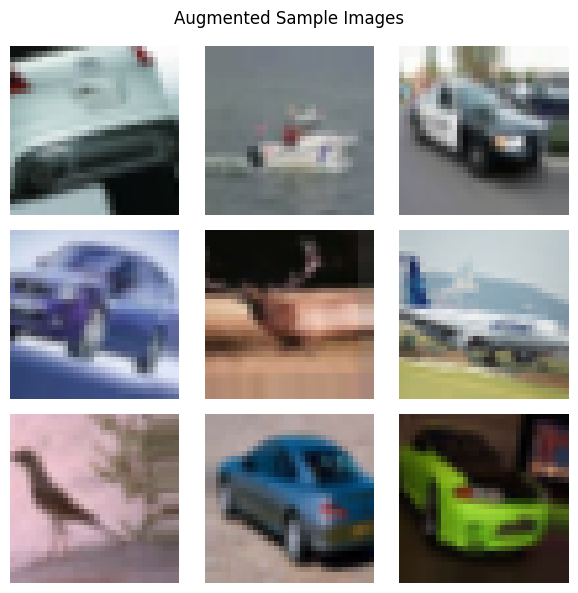

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(X_train)

# Visualize augmented images
for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    plt.figure(figsize=(6, 6))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.suptitle("Augmented Sample Images")
    plt.tight_layout()
    plt.show()
    break


Final Shape & Sanity Checks

In [8]:
print(f"x_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test_cat.shape}")

x_train: (50000, 32, 32, 3), y_train: (50000, 10)
X_test:  (10000, 32, 32, 3), y_test:  (10000, 10)


3.0 Model Building

3.1 2D CNN Baseline Model



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_3 (Dense)             (None, 64)             

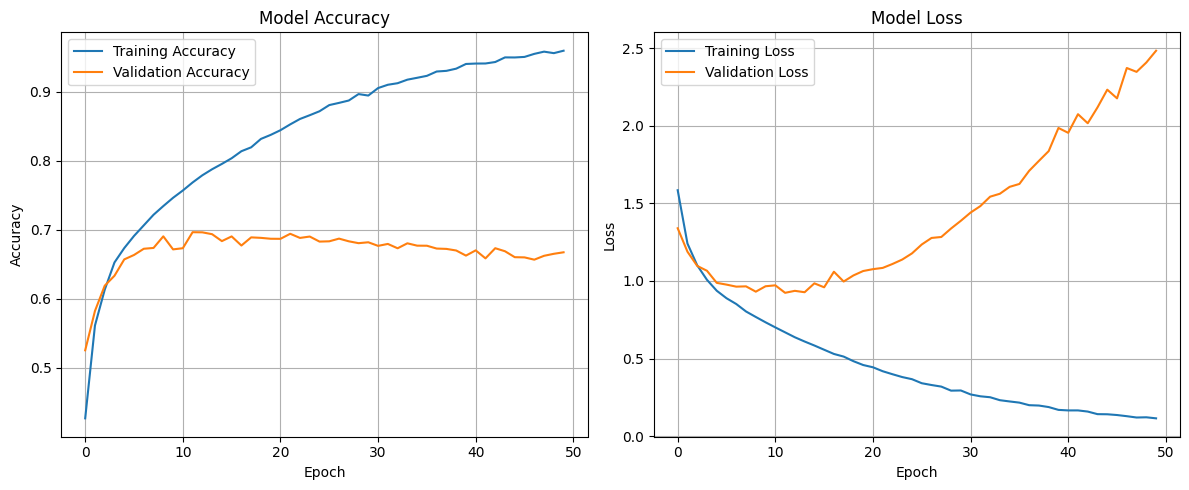

In [12]:
# Define minimal baseline 2D CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train the model
history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=64,
    validation_split=0.2
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test evaluation - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Predict on Validation Set

In [ ]:
# Predict on test set
y_pred_probs = model.predict(X_test) 
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

313/313 [==============================] - 1s 3ms/step


Classification Report & Confusion Matrix

              precision    recall  f1-score   support

           0     0.6516    0.7370    0.6917      1000
           1     0.7975    0.7640    0.7804      1000
           2     0.5395    0.5530    0.5462      1000
           3     0.4582    0.4110    0.4333      1000
           4     0.5802    0.6260    0.6022      1000
           5     0.5630    0.5410    0.5518      1000
           6     0.7465    0.7570    0.7517      1000
           7     0.7133    0.6990    0.7061      1000
           8     0.7870    0.7500    0.7680      1000
           9     0.7355    0.7370    0.7363      1000

    accuracy                         0.6575     10000
   macro avg     0.6572    0.6575    0.6568     10000
weighted avg     0.6572    0.6575    0.6568     10000



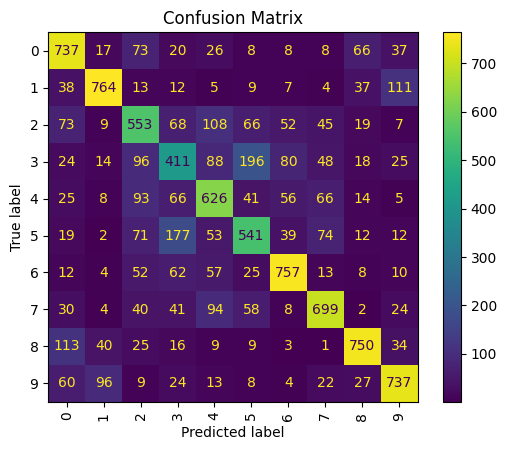

In [14]:
print(classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

3.2 Convolutional Multilayer Perceptron (ConvMLP) Baseline Model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_29 (Conv2D)          (None, 32, 32, 64)           1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_35 (Ba  (None, 32, 32, 64)           256       ['conv2d_29[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_35 (ReLU)             (None, 32, 32, 64)           0         ['batch_normalization_35

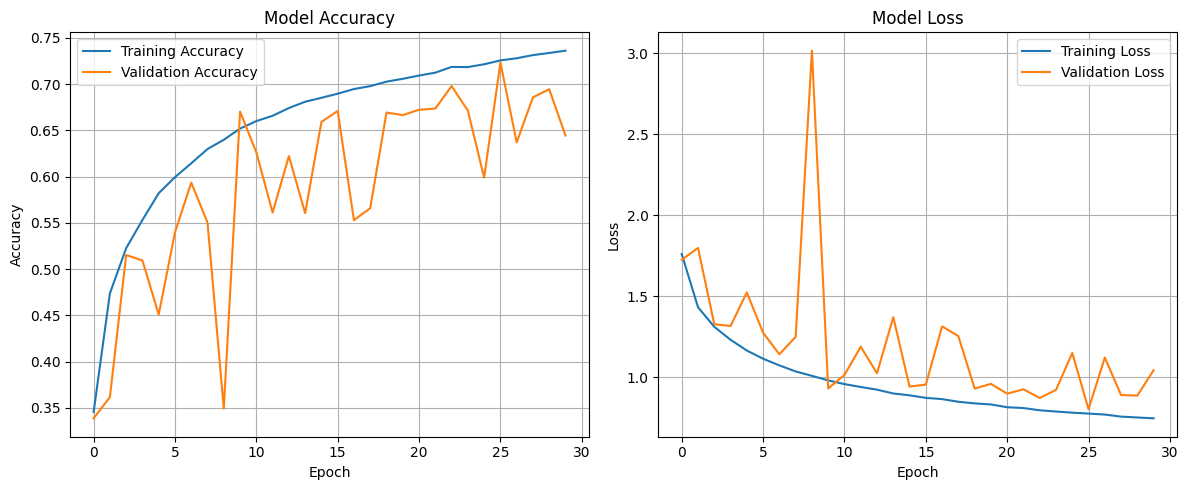

In [ ]:
# Baseline ConvMLP 
def build_convmlp_baseline():
    inp = Input((32, 32, 3))
    x = Conv2D(64, 3, padding='same')(inp)
    x = BatchNormalization()(x); x = ReLU()(x)

    # 1 Conv Block
    x = Conv2D(64, 1, padding='same')(x)
    x = BatchNormalization()(x); x = ReLU()(x)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x); x = ReLU()(x)
    x = Conv2D(64, 1, padding='same')(x)
    x = BatchNormalization()(x); x = ReLU()(x)

    # 1 Conv-MLP Block
    x_res = x
    x = Conv2D(64, 1, padding='same')(x)
    x = BatchNormalization()(x); x = ReLU()(x)
    x = DepthwiseConv2D(3, padding='same')(x)
    x = BatchNormalization()(x); x = ReLU()(x)
    x = Conv2D(64, 1, padding='same')(x)
    x = BatchNormalization()(x); x = ReLU()(x)
    x = tf.keras.layers.add([x, x_res])

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    out = Dense(10, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

baseline_model = build_convmlp_baseline()
baseline_model.summary()

history = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    verbose=2
)

# Evaluation
baseline_loss, baseline_acc = baseline_model.evaluate(X_test, y_test, verbose=0)
print(f"\n Baseline ConvMLP Accuracy: {baseline_acc:.4f}, Test evaluation - Loss: {baseline_loss:.4f}")

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()

Predict on Validataion Set

In [30]:
# Predict on test set
y_pred_probs = baseline_model.predict(X_test) 
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print(classification_report(y_true, y_pred, digits=4))

313/313 [==============================] - 12s 37ms/step
              precision    recall  f1-score   support

           0     0.8155    0.6410    0.7178      1000
           1     0.8815    0.8330    0.8566      1000
           2     0.4470    0.5740    0.5026      1000
           3     0.4912    0.3900    0.4348      1000
           4     0.4826    0.5680    0.5218      1000
           5     0.7275    0.3710    0.4914      1000
           6     0.4756    0.9350    0.6305      1000
           7     0.8651    0.5260    0.6542      1000
           8     0.8066    0.8050    0.8058      1000
           9     0.8594    0.8010    0.8292      1000

    accuracy                         0.6444     10000
   macro avg     0.6852    0.6444    0.6445     10000
weighted avg     0.6852    0.6444    0.6445     10000



Confusion Matrix

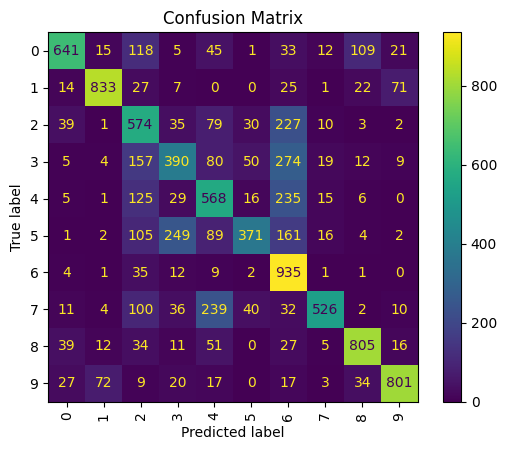

In [31]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

4.0 Model Tuning

4.1 2D CNN Model Using Random Search Tuning

Reloading Tuner from /mnt/data/tuner_results\cifar10_hyperparam_tuning\tuner0.json
313/313 [==============================] - 27s 87ms/step - loss: 59.1999 - accuracy: 0.8309
Best model evaluation - Loss: 59.19993209838867, Accuracy: 0.8309000134468079
Epoch 1/20
782/782 [==============================] - 503s 641ms/step - loss: 6.0168 - accuracy: 0.4544 - val_loss: 2.8557 - val_accuracy: 0.5640 - lr: 5.0000e-04
Epoch 2/20
782/782 [==============================] - 454s 581ms/step - loss: 2.2839 - accuracy: 0.5934 - val_loss: 2.2534 - val_accuracy: 0.5708 - lr: 5.0000e-04
Epoch 3/20
782/782 [==============================] - 454s 581ms/step - loss: 1.9650 - accuracy: 0.6339 - val_loss: 1.9655 - val_accuracy: 0.6244 - lr: 5.0000e-04
Epoch 4/20
782/782 [==============================] - 455s 581ms/step - loss: 1.9573 - accuracy: 0.6514 - val_loss: 2.3743 - val_accuracy: 0.5417 - lr: 5.0000e-04
Epoch 5/20
782/782 [==============================] - 466s 595ms/step - loss: 1.9504 - accuracy

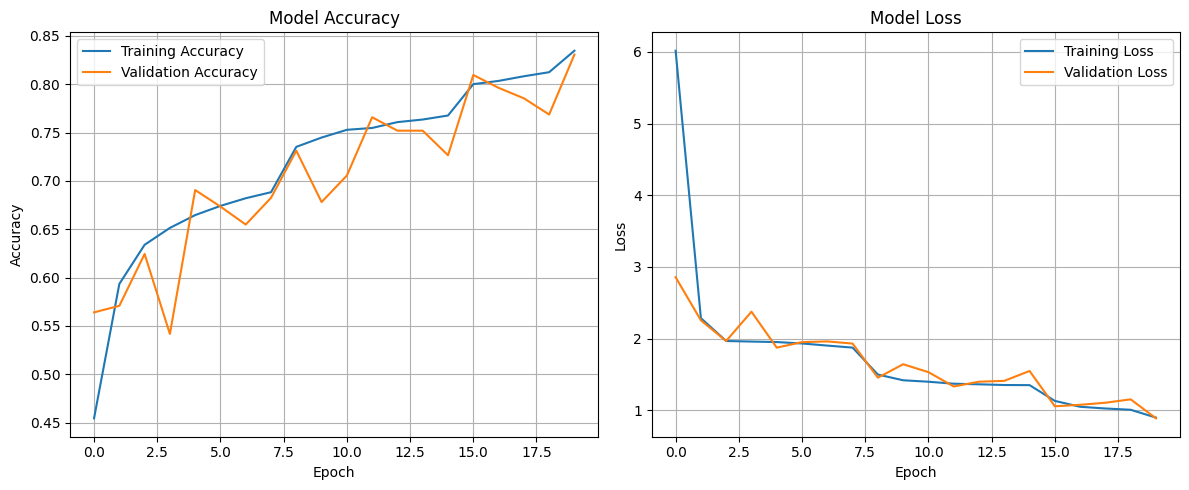

In [ ]:
# Define model builder function with L2 regularization
def build_model(hp):
    model = Sequential()
    
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_testue=128, step=32),
        kernel_size=3,
        activation='relu',
        padding='same',
        input_shape=(32, 32, 3),
        kernel_regularizer=l2(0.01)
    ))
    model.add(BatchNormalization())
    
    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_testue=128, step=32),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=l2(0.01)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(hp.Float('dropout1', 0.3, 0.6, step=0.1)))
    
    model.add(Conv2D(
        filters=hp.Int('conv3_filters', min_value=64, max_testue=256, step=64),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=l2(0.01)
    ))
    model.add(BatchNormalization())
    model.add(Conv2D(
        filters=hp.Int('conv4_filters', min_value=64, max_testue=256, step=64),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=l2(0.01)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(hp.Float('dropout2', 0.4, 0.7, step=0.1)))
    
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=128, max_testue=512, step=128),
        activation='relu',
        kernel_regularizer=l2(0.01)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout3', 0.4, 0.7, step=0.1)))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Setup callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Setup Random Search Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='/mnt/data/tuner_results',
    project_name='cifar10_hyperparam_tuning'
)

# Search for best hyperparameters
tuner.search(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=10,
    validation_data=(x_test, y_test)
)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
eval_result = best_model.evaluate(x_test, y_test)
print(f"Best model evaluation - Loss: {eval_result[0]}, Accuracy: {eval_result[1]}")

# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Rebuild and train the best model
model = build_model(best_hp)
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=20, 
    validation_data=(x_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

# Print final evaluation
final_eval = model.evaluate(x_test, y_test)
print(f"Final model evaluation - Loss: {final_eval[0]}, Accuracy: {final_eval[1]}")

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Rebuild & Train Best Model with 100 Epoch

Epoch 1/100
782/782 [==============================] - 441s 562ms/step - loss: 5.8000 - accuracy: 0.4570 - val_loss: 3.2081 - val_accuracy: 0.4628 - lr: 5.0000e-04
Epoch 2/100
782/782 [==============================] - 448s 573ms/step - loss: 2.2730 - accuracy: 0.5926 - val_loss: 2.0839 - val_accuracy: 0.5927 - lr: 5.0000e-04
Epoch 3/100
782/782 [==============================] - 447s 572ms/step - loss: 1.9631 - accuracy: 0.6318 - val_loss: 2.0375 - val_accuracy: 0.6292 - lr: 5.0000e-04
Epoch 4/100
782/782 [==============================] - 446s 570ms/step - loss: 1.9420 - accuracy: 0.6502 - val_loss: 1.9463 - val_accuracy: 0.6638 - lr: 5.0000e-04
Epoch 5/100
782/782 [==============================] - 446s 570ms/step - loss: 1.9377 - accuracy: 0.6662 - val_loss: 2.3066 - val_accuracy: 0.5637 - lr: 5.0000e-04
Epoch 6/100
782/782 [==============================] - 446s 570ms/step - loss: 1.9041 - accuracy: 0.6751 - val_loss: 2.0063 - val_accuracy: 0.6325 - lr: 5.0000e-04
Epoch 7/100
782/

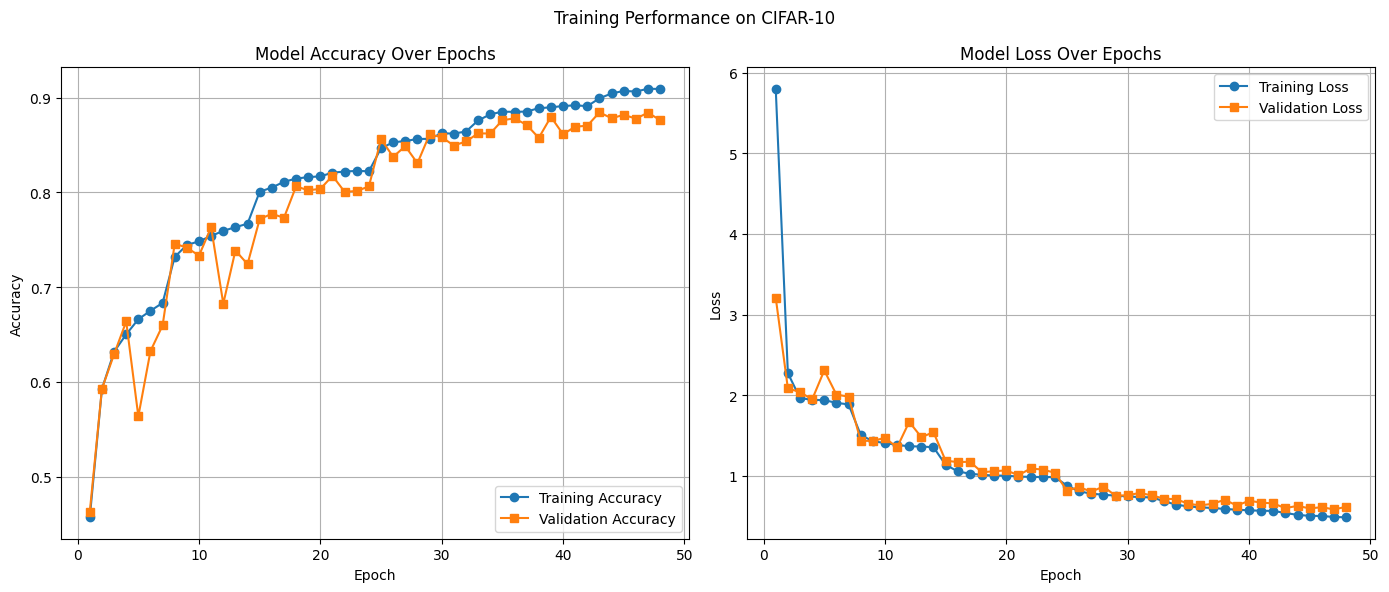

In [ ]:
# Rebuild and train the best model
model = build_model(best_hp)

# EarlyStopping to stop when val_accuracy doesn't improve
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # stops after 5 epochs with no improvement
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=100,  
    validation_data=(x_test, y_test),
    callbacks=[lr_scheduler, early_stopping]
)

# Final evaluation
final_eval = model.evaluate(x_test, y_test)
print(f"Final model evaluation - Loss: {final_eval[0]:.4f}, Accuracy: {final_eval[1]:.4f}")

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='s')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.suptitle('Training Performance on CIFAR-10')
    plt.tight_layout()
    plt.show()

# Call the function to display the plot
plot_training_history(history)


Best Parameters

In [ ]:
# Print best hyperparameters
print("Best Hyperparameters:")
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

Best Hyperparameters:
conv1_filters: 96
conv2_filters: 96
dropout1: 0.2
conv3_filters: 256
conv4_filters: 192
dropout2: 0.3
dense_units: 256
dropout3: 0.4
learning_rate: 0.0005


Predict on Validation Set

In [ ]:
# Predict
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 [==============================] - 21s 65ms/step


Classification Report

In [61]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9000    0.9090    0.9045      1000
           1     0.9264    0.9570    0.9415      1000
           2     0.8608    0.8470    0.8538      1000
           3     0.8945    0.6700    0.7662      1000
           4     0.8384    0.9030    0.8695      1000
           5     0.8820    0.8000    0.8390      1000
           6     0.8204    0.9640    0.8864      1000
           7     0.9017    0.9260    0.9137      1000
           8     0.9343    0.9380    0.9361      1000
           9     0.9014    0.9320    0.9164      1000

    accuracy                         0.8846     10000
   macro avg     0.8860    0.8846    0.8827     10000
weighted avg     0.8860    0.8846    0.8827     10000



Confusion Matrix

313/313 [==============================] - 21s 66ms/step


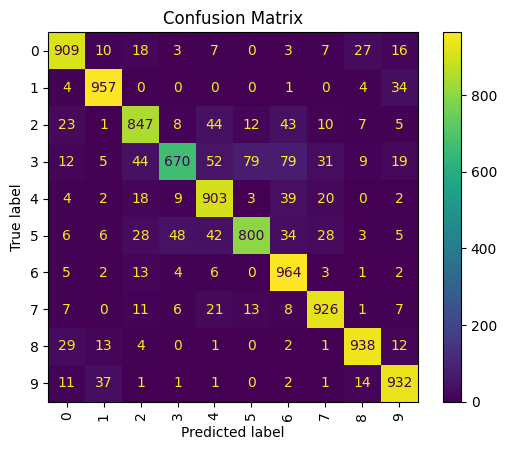

In [ ]:
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


Visualize Sample Predictions

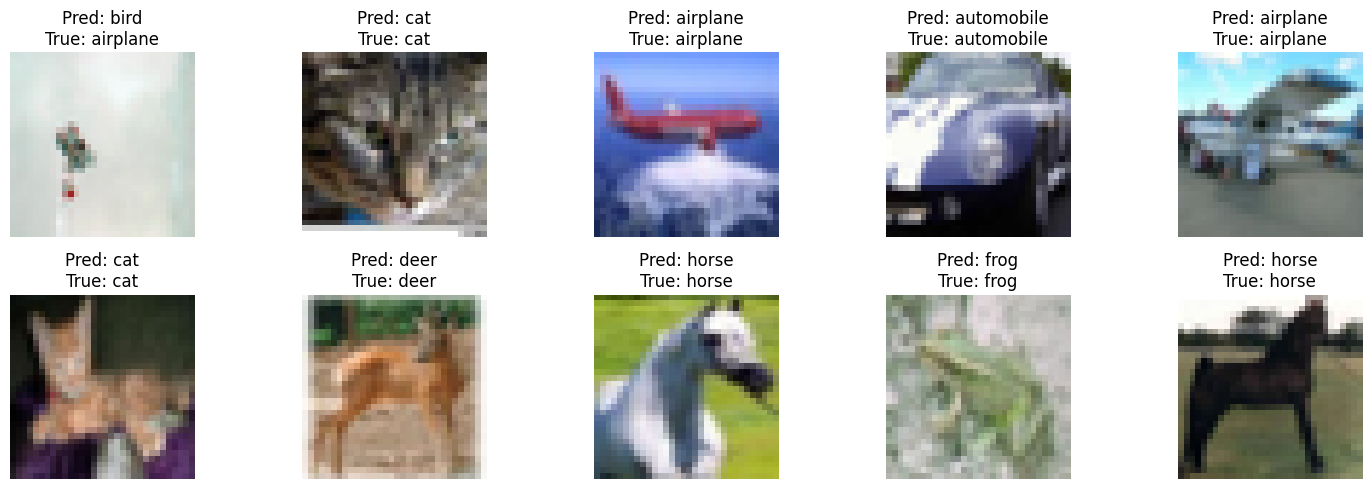

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Show 10 random samples
plt.figure(figsize=(15, 5))
for i in range(10):
    index = np.random.randint(0, len(x_test))
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[index])
    plt.axis('off')
    plt.title(f"Pred: {class_names[y_pred[index]]}\nTrue: {class_names[y_true[index]]}")
plt.tight_layout()
plt.show()


4.2 Convulutional Multilayer Perceptron (ConvMLP) Model Using Random Search

Trial 5 Complete [07h 21m 51s]
val_accuracy: 0.8296999931335449

Best val_accuracy So Far: 0.8349999785423279
Total elapsed time: 1d 06h 07m 00s
Best Hyperparameters:
{'conv_blocks': 2, 'conv_filters_0': 128, 'mlp_blocks': 3, 'mlp_filters_0': 128, 'dropout': 0.2, 'lr': 0.0005, 'conv_filters_1': 128, 'mlp_filters_1': 128, 'mlp_filters_2': 128}
Epoch 1/50
782/782 - 1122s - loss: 1.8699 - accuracy: 0.3797 - val_loss: 1.9161 - val_accuracy: 0.3925 - lr: 5.0000e-04 - 1122s/epoch - 1s/step
Epoch 2/50
782/782 - 1099s - loss: 1.4594 - accuracy: 0.5225 - val_loss: 2.3952 - val_accuracy: 0.3612 - lr: 5.0000e-04 - 1099s/epoch - 1s/step
Epoch 3/50
782/782 - 1093s - loss: 1.2816 - accuracy: 0.5894 - val_loss: 2.1454 - val_accuracy: 0.4134 - lr: 5.0000e-04 - 1093s/epoch - 1s/step
Epoch 4/50
782/782 - 1075s - loss: 1.1649 - accuracy: 0.6326 - val_loss: 1.9417 - val_accuracy: 0.4683 - lr: 5.0000e-04 - 1075s/epoch - 1s/step
Epoch 5/50
782/782 - 1088s - loss: 1.0276 - accuracy: 0.6817 - val_loss: 1.5255

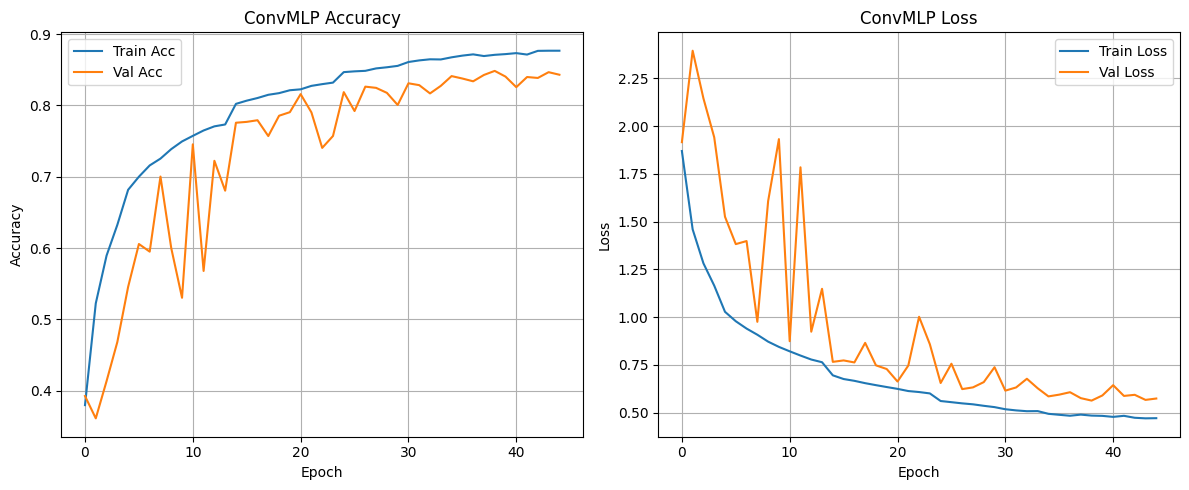

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(X_train)

# Model Builder for Tuner
def build_convmlp(hp):
    inp = Input((32, 32, 3))
    
    # Tokenizer
    x = Conv2D(128, 3, padding='same', kernel_regularizer=l2(1e-4))(inp)
    x = BatchNormalization()(x); x = ReLU()(x)

    # Conv Blocks
    for i in range(hp.Int('conv_blocks', 1, 3)):
        filters = hp.Choice(f'conv_filters_{i}', [64, 128])
        x = Conv2D(filters, 1, padding='same', kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x); x = ReLU()(x)
        x = Conv2D(filters, 3, padding='same', kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x); x = ReLU()(x)
        x = Conv2D(filters, 1, padding='same', kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x); x = ReLU()(x)

    # ConvMLP Blocks
    for i in range(hp.Int('mlp_blocks', 1, 3)):
        filters = hp.Choice(f'mlp_filters_{i}', [64, 128])
        x_res = x
        x = Conv2D(filters, 1, padding='same', kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x); x = ReLU()(x)
        x = DepthwiseConv2D(3, padding='same')(x)
        x = BatchNormalization()(x); x = ReLU()(x)
        x = Conv2D(filters, 1, padding='same', kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x); x = ReLU()(x)
        if x.shape[-1] == x_res.shape[-1]:
            x = tf.keras.layers.add([x, x_res])

    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(x)
    out = Dense(10, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 5e-4, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Tuner Setup
tuner = RandomSearch(
    build_convmlp,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='convmlp_tuner_hyper',
    project_name='cifar10_convmlp_tuned'
)

# Callbacks
early_stop = EarlyStopping(patience=6, monitor='val_loss', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Search Best Hyperparameters
tuner.search(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# Retrieve Best Hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print(f"Best Hyperparameters:\n{best_hp.values}")

# Rebuild & Retrain Best Model
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
  
# Final Evaluation
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\n🔹 Final ConvMLP (Tuned) Accuracy: {test_acc:.4f}")

# Plot Results
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('ConvMLP Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('ConvMLP Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


Print Best Hyperparameter

In [16]:
print("\nBest Hyperparameters:")
for param in best_hp.values:
    print(f"{param}: {best_hp.get(param)}")


Best Hyperparameters:
conv_blocks: 2
conv_filters_0: 128
mlp_blocks: 3
mlp_filters_0: 128
dropout: 0.2
lr: 0.0005
conv_filters_1: 128
mlp_filters_1: 128
mlp_filters_2: 128


Predict on Validation Set

In [21]:
# Predict
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 [==============================] - 65s 207ms/step


Print Classification Report

In [22]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8845    0.8350    0.8591      1000
           1     0.8747    0.9630    0.9167      1000
           2     0.7852    0.7970    0.7911      1000
           3     0.7740    0.7090    0.7401      1000
           4     0.8462    0.7810    0.8123      1000
           5     0.8573    0.7510    0.8006      1000
           6     0.7731    0.9470    0.8512      1000
           7     0.8982    0.8650    0.8813      1000
           8     0.9053    0.9180    0.9116      1000
           9     0.8983    0.9190    0.9086      1000

    accuracy                         0.8485     10000
   macro avg     0.8497    0.8485    0.8473     10000
weighted avg     0.8497    0.8485    0.8473     10000



Confussion Matrix

313/313 [==============================] - 64s 204ms/step


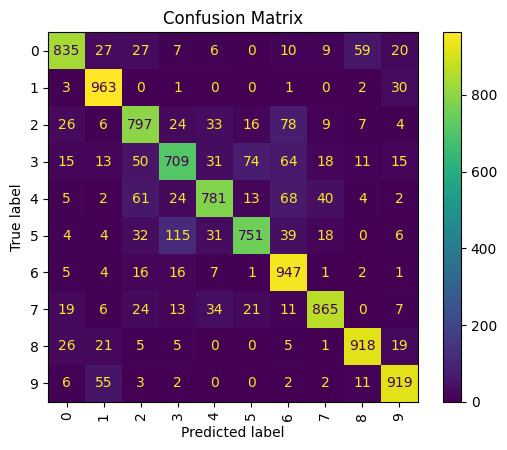

In [23]:
y_pred_probs = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

Visualize Sample Prediction

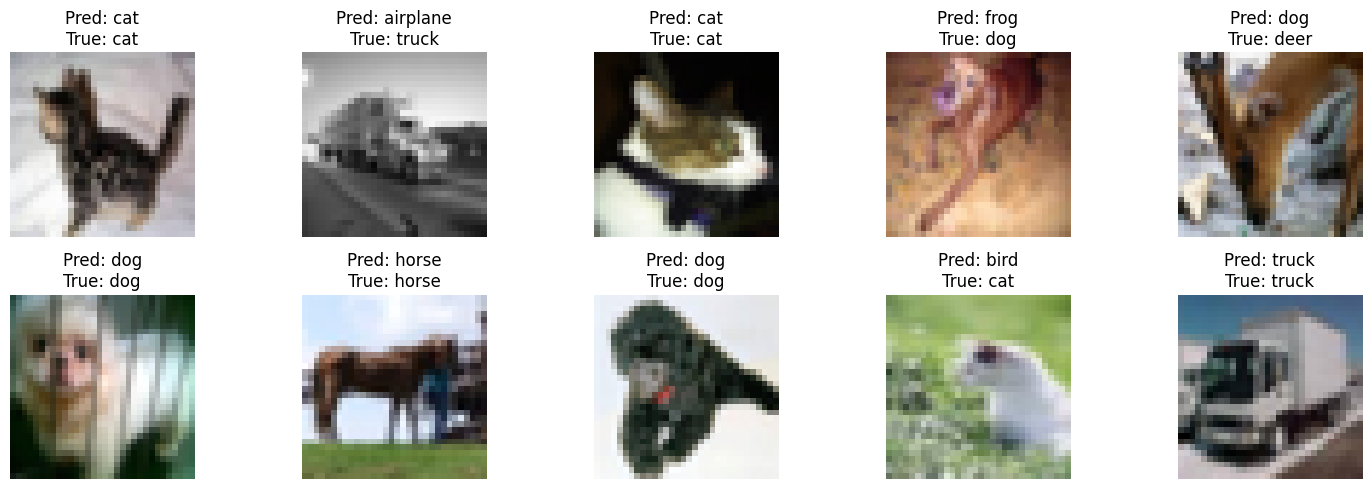

In [28]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Show 10 random samples
plt.figure(figsize=(15, 5))
for i in range(10):
    index = np.random.randint(0, len(X_test))
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[index])
    plt.axis('off')
    plt.title(f"Pred: {class_names[y_pred[index]]}\nTrue: {class_names[y_true[index]]}")
plt.tight_layout()
plt.show()
